# Fluorescence assay prepared with a Tecan HP D300 digital dispenser

A summary of the experimental procedure goes here

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

In [2]:
%matplotlib inline

In [3]:
import re
import pymc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load data from Tecan iControl XML file.
from assaytools import platereader

row_names = ['A - Src','B - Buffer','C - Src','D - Buffer', 'E - Src','F - Buffer','G - Src','H - Buffer'] # row info

filename = "data/SrcTI_WIP_SMH_SrcBos_111814_mdfx_20150121_175828.xml"

sections = platereader.read_icontrol_xml(filename)

In [5]:
# Extract observed fluorescence signals
complex_row = 'A'
ligand_row = 'B'

top_complex_fluorescence = sections['TopRead']['rows'][complex_row]
top_ligand_fluorescence = sections['TopRead']['rows'][ligand_row]
bottom_complex_fluorescence = sections['BottomRead']['rows'][complex_row]
bottom_ligand_fluorescence = sections['BottomRead']['rows'][ligand_row]

# Stated concentrations of protein and ligand.
Pstated = 0.5e-6 * np.ones([12],np.float64) # protein concentration, M
Lstated = np.array([20.0e-6,9.15e-6,4.18e-6,1.91e-6,0.875e-6,0.4e-6,0.183e-6,0.0837e-6,0.0383e-6,0.0175e-6,0.008e-6,0.0001e-6], np.float64)
# Protein concentration (M) (modified form from Sonya, replacing 0 with a small number because we can't handle zero concentrations yet)

In [6]:
# Assay configuration details
import math
assay_volume = 100e-6 # assay volume, L
well_area = 0.3969 # well area, cm^2 for 4ti-0223 [http://4ti.co.uk/files/1614/0542/7662/4ti-0223_Marketing_Drawing.pdf]
#ravg = (0.696/2. + 0.658/2.)/2. # average radius for Greiner UV-Star 96-well flat-bottom plates: http://www.greinerbioone.com/nl/belgium/files/1464609/655809.pdf
#well_area = math.pi * ravg**2 
path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections     

# Uncertainties in protein and ligand concentrations.
dPstated = 0.35 * Pstated # protein concentration uncertainty
dLstated = 0.08 * Lstated # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

In [7]:
# Create the pymc model
from assaytools import pymcmodels
pymc_model = pymcmodels.make_model(Pstated, dPstated, Lstated, dLstated, 
               top_complex_fluorescence=top_complex_fluorescence,
               top_ligand_fluorescence=top_ligand_fluorescence,
               #bottom_complex_fluorescence=bottom_complex_fluorescence,
               #bottom_ligand_fluorescence=bottom_ligand_fluorescence,
               use_primary_inner_filter_correction=True, 
               use_secondary_inner_filter_correction=True, 
               assay_volume=assay_volume, well_area=well_area, DG_prior='uniform')

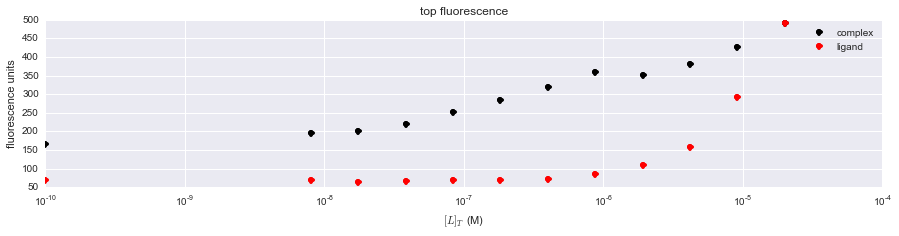

In [8]:
from assaytools import plots
figure = plots.plot_measurements(Lstated, Pstated, pymc_model)

In [9]:
# Find the maximum a posteriori fit (will only be local optimum, and several cycles are needed for reasonable fit)
map = pymcmodels.map_fit(pymc_model)

MAP fitting cycle 5/5


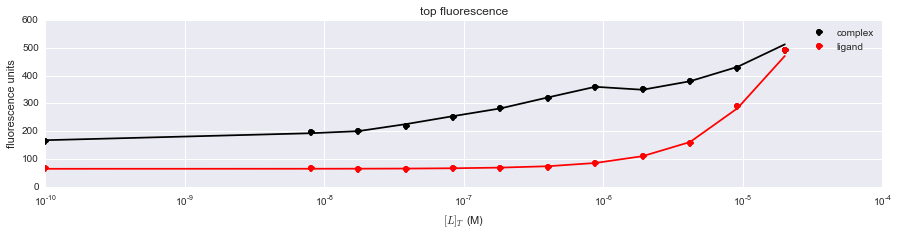

In [10]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)

In [11]:
# Sample the model posterior with MCMC
mcmc = pymcmodels.run_mcmc(pymc_model)

(1000,)


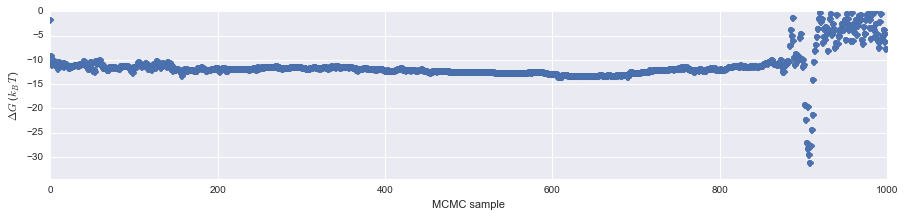

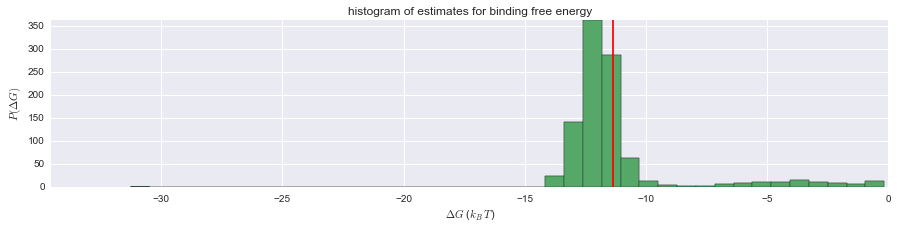

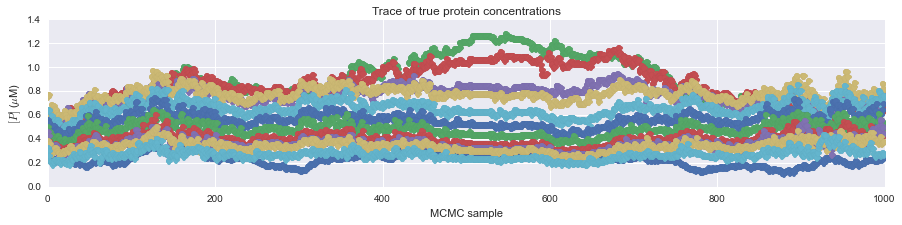

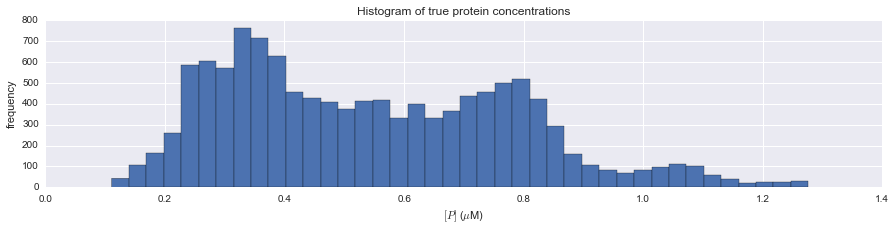

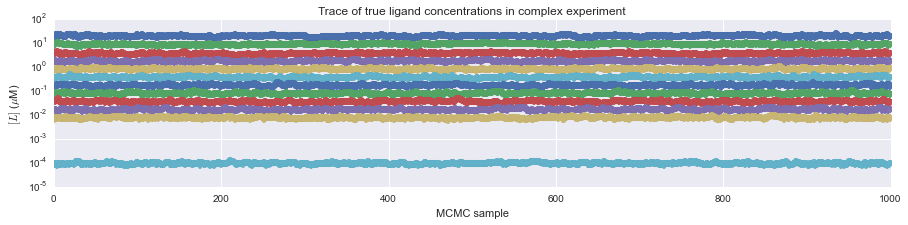

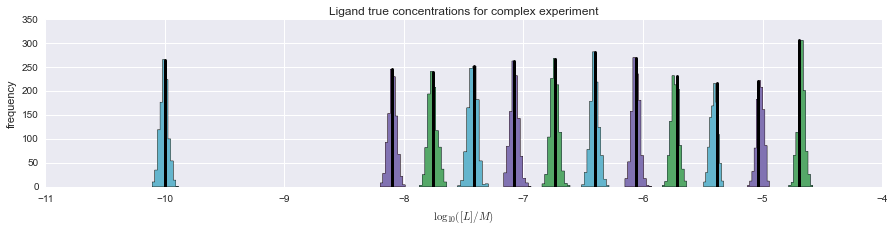

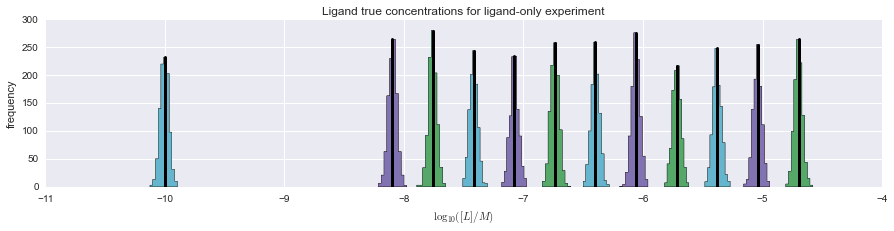

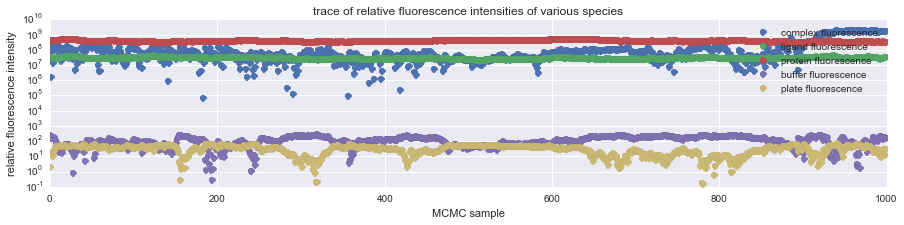

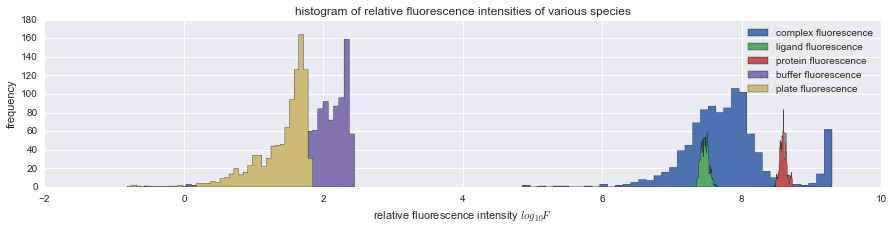

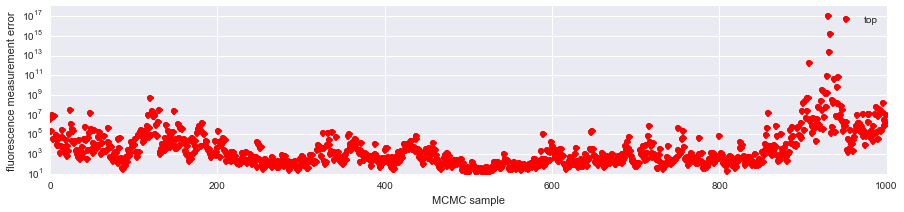

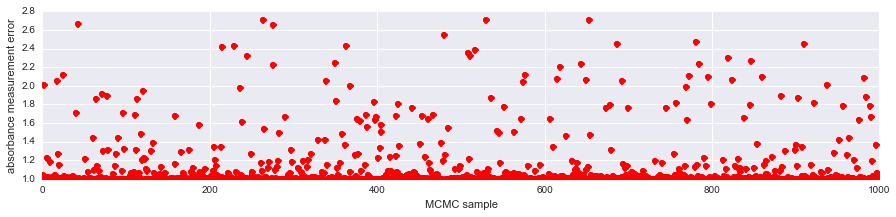

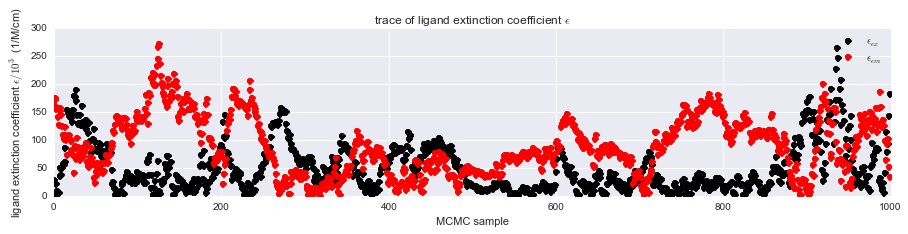

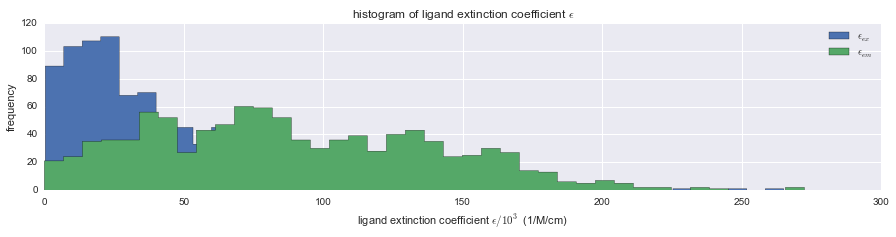

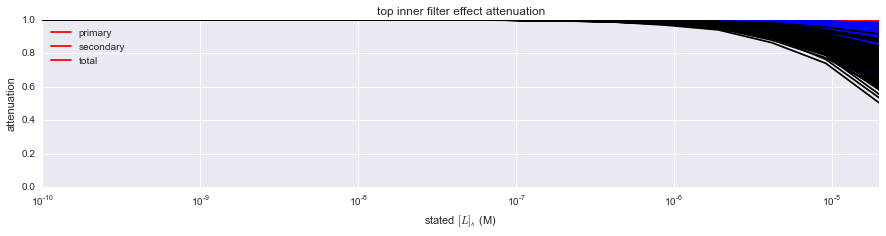

In [12]:
plots.plot_mcmc_results(Lstated, Pstated, path_length, mcmc)

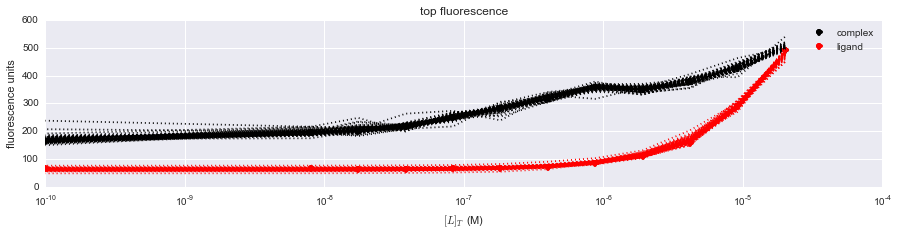

In [13]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, mcmc=mcmc)

In [14]:
# Fit maximum a posteriori estimate one more time
map = pymcmodels.map_fit(pymc_model)

MAP fitting cycle 5/5


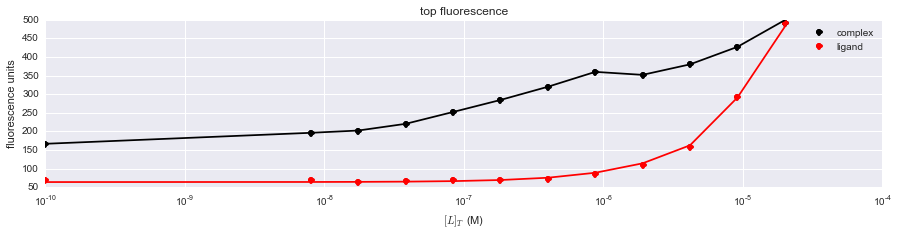

In [15]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)

In [16]:
pymcmodels.show_summary(pymc_model, map, mcmc)

DeltaG = -1.5 +- 2.9 kT
Kd = 215.1 mM +- 68.4 mM


This is a LaTeX equation: $x + x^2$